In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
def RunActiveLearning(n_queries, estimator, query_strategy, initial_idx):
    # initialization
    X_initial, y_initial = X_train[initial_idx], np.ravel(y_train[initial_idx])
    X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
    # create instance
    learner = ActiveLearner(
        estimator=estimator,
        query_strategy=query_strategy,
        X_training=X_initial, y_training=y_initial
    )
    # training
    train_accuracy = [learner.score(X_train, y_train)]
    test_accuracy = [learner.score(X_test, y_test)]
    for i in range(n_queries):
        # Active Learning
        query_idx, _ = learner.query(X_pool)
        learner.teach(X_pool[query_idx].reshape(1, -1), np.ravel(y_pool[query_idx]))
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        train_accuracy.append(learner.score(X_train, y_train))
        test_accuracy.append(learner.score(X_test, y_test))
    return train_accuracy, test_accuracy

def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

def RunRandomSampling(n_queries, estimator, initial_idx):
    # initialization
    X_initial, y_initial = X_train[initial_idx], np.ravel(y_train[initial_idx])
    X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
    # create instance
    learner = ActiveLearner(
        estimator=estimator,
        query_strategy=random_sampling,
        X_training=X_initial, y_training=y_initial
    )
    # training
    train_accuracy = [learner.score(X_train, y_train)]
    test_accuracy = [learner.score(X_test, y_test)]
    for i in range(n_queries):
        # Active Learning
        query_idx, _ = learner.query(X_pool)
        learner.teach(X_pool[query_idx].reshape(1, -1), np.ravel(y_pool[query_idx]))
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        train_accuracy.append(learner.score(X_train, y_train))
        test_accuracy.append(learner.score(X_test, y_test))
    return train_accuracy, test_accuracy

def PlotLearningCurve(n_queries, accuracy):
    # plot learning curve
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        plt.title('Accuracy of the classifier during the active learning')
        plt.plot(range(n_queries+1), accuracy["train_accuracy"])
        plt.scatter(range(n_queries+1), accuracy["train_accuracy"])
        plt.plot(range(n_queries+1), accuracy["test_accuracy"])
        plt.scatter(range(n_queries+1), accuracy["test_accuracy"])
        plt.plot(range(n_queries+1), accuracy["random_train_accuracy"], '--', color="lightblue", alpha=0.5)
        plt.scatter(range(n_queries+1), accuracy["random_train_accuracy"], color="lightblue", alpha=0.5)
        plt.plot(range(n_queries+1), accuracy["random_test_accuracy"], '--', color="bisque", alpha=0.5)
        plt.scatter(range(n_queries+1), accuracy["random_test_accuracy"], color="bisque", alpha=0.5)
        plt.axhline(y=accuracy["train_reference"], color="midnightblue", linestyle=':')
        plt.axhline(y=accuracy["test_reference"], color="chocolate", linestyle=':')
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        plt.legend(["train accuracy", "test accuracy", \
            "random train accuracy", "random test accuracy",\
            "train reference", "test reference"])
        plt.show()


In [42]:
# get training data
X_train_path = "./UCI HAR Dataset/train/X_train.txt"
X_train = np.array(pd.read_table(X_train_path, delim_whitespace=True, header=None))
y_train_path = "./UCI HAR Dataset/train/y_train.txt"
y_train = np.array(pd.read_table(y_train_path, delim_whitespace=True, header=None))
# get test data
X_test_path = "./UCI HAR Dataset/test/X_test.txt"
X_test = np.array(pd.read_table(X_test_path, delim_whitespace=True, header=None))
y_test_path = "./UCI HAR Dataset/test/y_test.txt"
y_test = np.array(pd.read_table(y_test_path, delim_whitespace=True, header=None))

In [45]:
# baseline model
result = dict()
ref_model = RandomForestClassifier()
ref_model.fit(X_train, np.ravel(y_train))
result["train_reference"] = ref_model.score(X_train, np.ravel(y_train))
result["test_reference"] = ref_model.score(X_test, np.ravel(y_test))

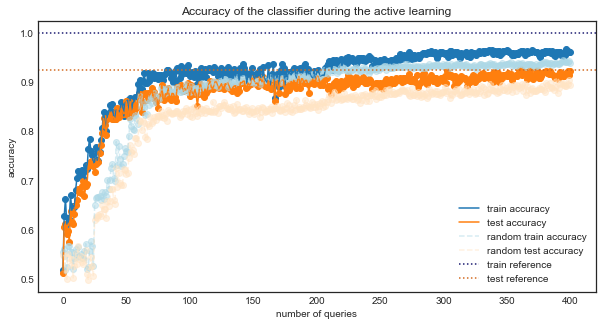

In [50]:
n_initial = 20
n_queries = 400
estimator = RandomForestClassifier()
query_strategy = uncertainty_sampling
np.random.seed(0)
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
result["train_accuracy"], result["test_accuracy"] = \
    RunActiveLearning(n_queries, estimator, query_strategy, initial_idx)
result["random_train_accuracy"], result["random_test_accuracy"] = \
    RunRandomSampling(n_queries, estimator, initial_idx)
PlotLearningCurve(n_queries, result)